# Question 4-5

In [1]:
import json
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from statistics import mean
import statsmodels.api as sm

/home/fs/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
path = "../../projects/project_5/ECE219_tweet_data/"

files = ["tweets_#gohawks.txt", "tweets_#gopatriots.txt", \
        "tweets_#nfl.txt", "tweets_#patriots.txt", \
        "tweets_#sb49.txt", "tweets_#superbowl.txt"]
topics = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]

for i, fl in enumerate(files):
    print("files[" + str(i) + "] => " + fl)

files[0] => tweets_#gohawks.txt
files[1] => tweets_#gopatriots.txt
files[2] => tweets_#nfl.txt
files[3] => tweets_#patriots.txt
files[4] => tweets_#sb49.txt
files[5] => tweets_#superbowl.txt


#### Here we need to choose features by ourselves. The features in previous part are kept except for hour of the day. Find new features to use in the twitter object

In [3]:
tmp_path = "../../projects/project_5/ECE219_tweet_data/"
tmp_file = 'tmp.txt'
tmp_a = []
for line in open(tmp_path + tmp_file, 'r'):
    tmp_a.append(json.loads(line))
    
a_show = tmp_a[1]

print(json.dumps(a_show, indent=4, sort_keys=True))

{
    "author": {
        "author_img": "http://pbs.twimg.com/profile_images/3500051520/6df4b26b0f9af8bb521415c665f9f257_normal.jpeg",
        "description": "Native Spanish tutor / teacher with 12 years experience with students of all ages in downtown Bellevue, WA.",
        "followers": 51.0,
        "image_url": "http://pbs.twimg.com/profile_images/3500051520/6df4b26b0f9af8bb521415c665f9f257_normal.jpeg",
        "name": "Jennifer P.",
        "nick": "bellevuespanish",
        "type": "twitter",
        "url": "http://twitter.com/bellevuespanish"
    },
    "citation_date": 1421538677,
    "citation_url": "http://twitter.com/BellevueSpanish/status/556599673738100736",
    "firstpost_date": 1421538677,
    "highlight": "Free Lyft ride up to $10 for first-timers using link http://t.co/OppoRltpDg  #Gohawks http://t.co/JW42hvna3F",
    "metrics": {
        "acceleration": 0,
        "citations": {
            "data": [
                {
                    "citations": 0,
             

number of mentioned user in this tweet

In [4]:
len(a_show['tweet']['entities']['user_mentions'])

0

number of media url attached

In [5]:
len(a_show['tweet']['extended_entities']['media']) if 'extended_entities' in a_show['tweet'] else 0

1

activite index defined by year

In [6]:
# total number of tweets posted by the user since account created
hist_tweet = a_show['tweet']['user']["statuses_count"]

# year the account was created
hist_year = a_show['tweet']['user']['created_at'][-4:]

# active index defined by year
hist_tweet/(2015-float(hist_year)+1)

314.3333333333333

author name

In [7]:
a_show['author']['name']

'Jennifer P.'

user's favourites count

In [30]:
a_show['tweet']['user']['favourites_count']

11

#### Prepare for data

In [8]:
def prase_dataset(file):
    """
    Prase x conponent of the dataset into pandas DataFrame including columns of:
    tweets, retweets, total_followers, max_followers, mentioned, media, active, author
    with lines of hours,
    where mentioned: number of @ in tweets per hour
          media: number of url in tweets per hour
          active: a measure of active state of author
          author: number of unique authors post tweet per hour
    Prase y of dataset as number of tweets in the next hour.
    """
   
    # extract raw features
    pst_tz = pytz.timezone('America/Los_Angeles')
    data_raw = []
    for line in open(path + file, 'r') :
        row_tmp = []
        a = json.loads(line)
        time = a['citation_date']
        retweet = a['metrics']['citations']['total']
        foll = a['author']['followers']             
        ment = len(a['tweet']['entities']['user_mentions'])        
        medi = len(a['tweet']['extended_entities']['media']) if 'extended_entities' in a['tweet'] else 0
        hist_tw = a['tweet']['user']["statuses_count"]
        hist_yr = a['tweet']['user']['created_at'][-4:]
        acti = hist_tw/(2015-float(hist_yr)+1) 
        auth = a['author']['name']
        row_tmp.append(time)
        row_tmp.append(retweet)
        row_tmp.append(foll)    
        row_tmp.append(ment) 
        row_tmp.append(medi) 
        row_tmp.append(acti)  
        row_tmp.append(auth)
        data_raw.append(row_tmp)
    
    # sort according to time
    pddata_raw = pd.DataFrame(data_raw,columns=['time','retweets','followers','mentioned','media','active','author'])
    pddata_raw = pddata_raw.sort_values(by = 'time')
    pddata_raw = pddata_raw.reset_index(drop=True)
    pddata_raw['tweets'] = 1                   
#     print(pddata_raw)

    # reset time to hour index
    hour_accu = []
    hour_day = []
    for index, row in pddata_raw.iterrows():  
        p = datetime.datetime.fromtimestamp(row["time"], pst_tz)  
        hour_accu.append(((p.month-1)*31+p.day-14)*24+p.hour)
        hour_day.append(p.hour)    
    pddata_raw["time"] = hour_accu
    pddata_raw["hour of day"] = hour_day
    
    # create a new dataframe with desired form
    df = pd.DataFrame([],columns=['hour index','tweets','retweets','followers sum','followers max','mentioned','media','active','author'])
    df['hour index'] = range(pddata_raw.iloc[len(pddata_raw.index)-1,0]+1)
    df['tweets'] = pddata_raw.groupby("time")['tweets'].sum()
    df['retweets'] = pddata_raw.groupby("time")['retweets'].sum()
    df['followers sum'] = pddata_raw.groupby("time")['followers'].sum()
    df['followers max'] = pddata_raw.groupby("time")["followers"].max()
    df['mentioned'] = pddata_raw.groupby("time")['mentioned'].sum()
    df['media'] = pddata_raw.groupby("time")['media'].sum()
    df['active'] = pddata_raw.groupby("time")['active'].mean()  
    
    # count number of not-repeating authors
    df['author'] = pddata_raw.groupby("time")['author'].nunique() 
    
    # reset index of df
    df = df.drop([0]).fillna(0).reset_index(drop=True)

    # assign number of tweets of the next hour to be the target value
    df_y = df.iloc[1:,1].reset_index(drop=True)
    df = df[:len(df_y)]
    
    return df.iloc[:,1:],df_y

#### Train linear regression model

In [9]:
def train_lr(i):
    """
    This function gets data and train using a linear regression model
    """    
    df, df_y = prase_dataset(files[i])

    reg = LinearRegression().fit(df, df_y)
    pred_y = reg.predict(df)
    MSE = mean_squared_error(df_y, pred_y)
    R2 = r2_score(df_y, pred_y)
    
    print(topics[i])
    print('MSE for test data = ',MSE)
    print('R2 score for test data = ',R2)   
    
    return df, df_y, pred_y

In [10]:
def plot_recipe(df_y, pred_y):
    """
    This function plots fitted values vs true values
    """
    plt.figure()
    area = np.pi * (4)**2/4
    plt.scatter(df_y, pred_y, s = area)
    plt.plot([df_y.min(), df_y.max()], [df_y.min(), df_y.max()], 'k--', lw = 1)
    plt.xlabel('true values')
    plt.ylabel('fitted values')
    plt.show()

In [11]:
features = ['tweets', 'retweets', 'followers sum', 'followers max', \
            'mentioned', 'media', 'active', 'author']

def plot_feature_vs_pred(df,pred_y,features,top3):
    for i in top3:
        plt.figure()
        area = np.pi * (4)**2/4
        plt.scatter(df[features[i]], pred_y, s = area)
        plt.xlabel('feature: '+features[i])
        plt.ylabel('fitted values')
    plt.show()        

In [12]:
def ols_regression(df, df_y):
    X2 = sm.add_constant(df)
    y = df_y.as_matrix()
    lm = sm.OLS(y, X2).fit()
    print(lm.summary())
    print(list(df))

## Results

#### gohawks

gohawks
MSE for test data =  603736.5723990161
R2 score for test data =  0.5840035669124017


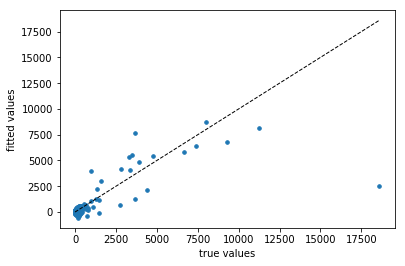

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     99.67
Date:                Wed, 20 Mar 2019   Prob (F-statistic):          5.19e-103
Time:                        00:06:36   Log-Likelihood:                -4658.9
No. Observations:                 577   AIC:                             9336.
Df Residuals:                     568   BIC:                             9375.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            76.3552     53.492      1.427

In [13]:
df, df_y, pred_y = train_lr(0)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

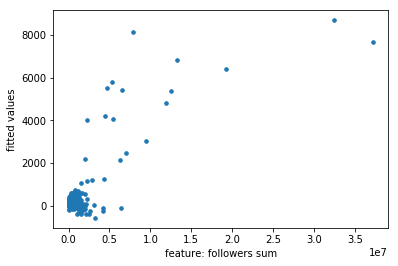

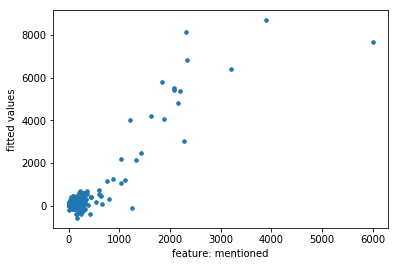

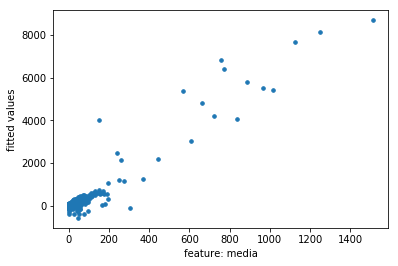

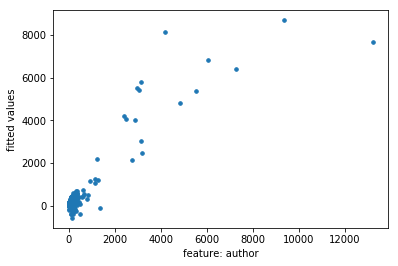

In [14]:
plot_feature_vs_pred(df,pred_y,features,[2,4,5])

#### gopatriots

gopatriots
MSE for test data =  10481.440131077052
R2 score for test data =  0.8591784345947171


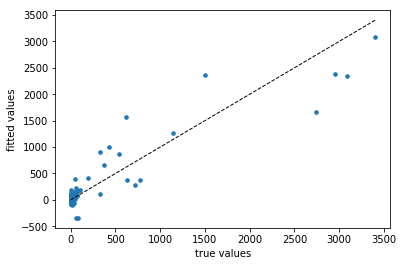

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     430.9
Date:                Wed, 20 Mar 2019   Prob (F-statistic):          7.69e-235
Time:                        00:06:39   Log-Likelihood:                -3471.3
No. Observations:                 574   AIC:                             6961.
Df Residuals:                     565   BIC:                             7000.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -7.7351      5.197     -1.488

In [15]:
df, df_y, pred_y = train_lr(1)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

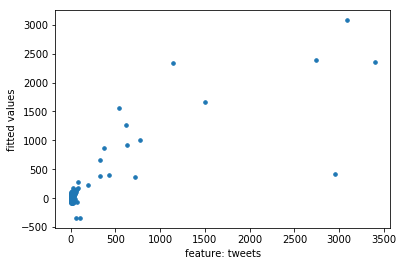

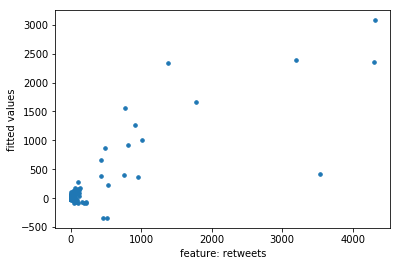

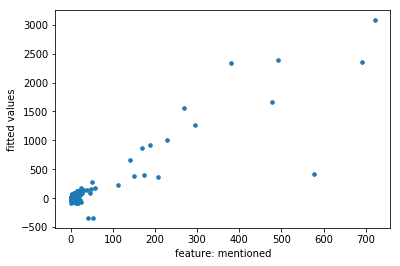

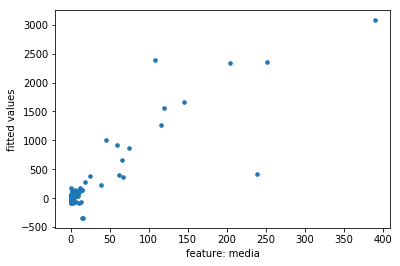

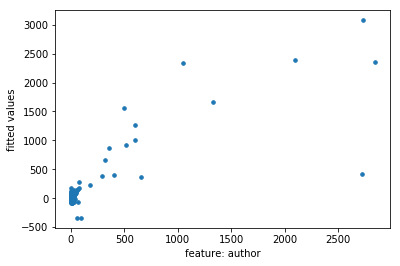

In [16]:
plot_feature_vs_pred(df,pred_y,features,[0,5,7])

#### nfl

nfl
MSE for test data =  207188.7005417895
R2 score for test data =  0.6711123746928491


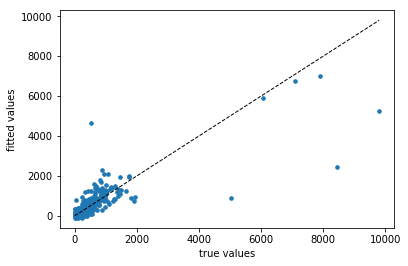

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     146.9
Date:                Wed, 20 Mar 2019   Prob (F-statistic):          1.00e-133
Time:                        00:07:04   Log-Likelihood:                -4410.7
No. Observations:                 585   AIC:                             8839.
Df Residuals:                     576   BIC:                             8879.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           119.4254     64.156      1.861

In [17]:
df, df_y, pred_y = train_lr(2)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

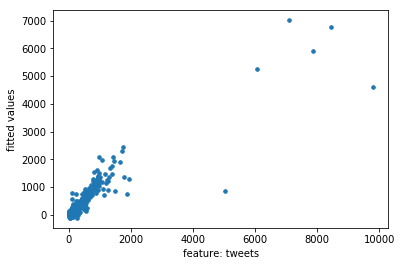

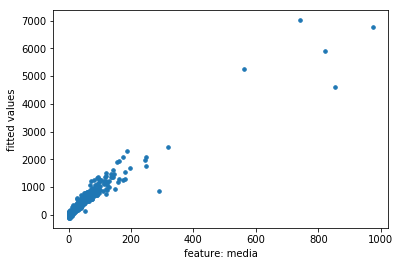

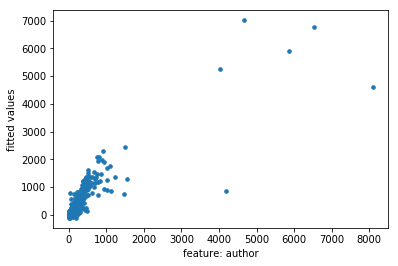

In [18]:
plot_feature_vs_pred(df,pred_y,features,[0,5,7])

#### patriots

patriots
MSE for test data =  3818325.496735968
R2 score for test data =  0.7560307512272275


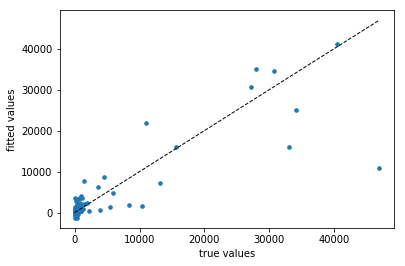

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     223.1
Date:                Wed, 20 Mar 2019   Prob (F-statistic):          6.29e-171
Time:                        00:07:47   Log-Likelihood:                -5263.0
No. Observations:                 585   AIC:                         1.054e+04
Df Residuals:                     576   BIC:                         1.058e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           376.9514    189.357      1.991

In [19]:
df, df_y, pred_y = train_lr(3)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

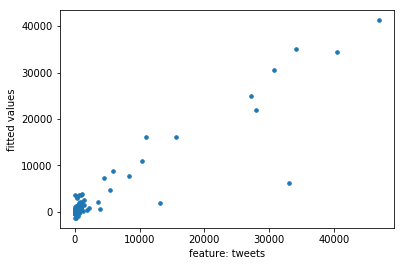

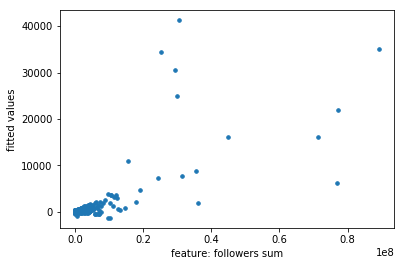

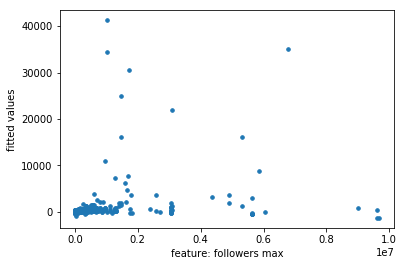

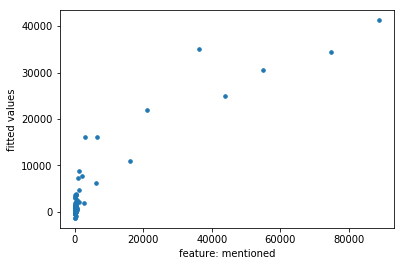

In [20]:
plot_feature_vs_pred(df,pred_y,features,[2,3,4])

#### sb49

sb49
MSE for test data =  13143188.639250018
R2 score for test data =  0.8405473314889264


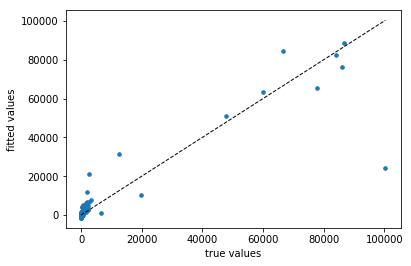

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     379.5
Date:                Wed, 20 Mar 2019   Prob (F-statistic):          5.51e-224
Time:                        00:11:40   Log-Likelihood:                -5624.6
No. Observations:                 585   AIC:                         1.127e+04
Df Residuals:                     576   BIC:                         1.131e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -180.8778    213.426     -0.847

In [24]:
df, df_y, pred_y = train_lr(4)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

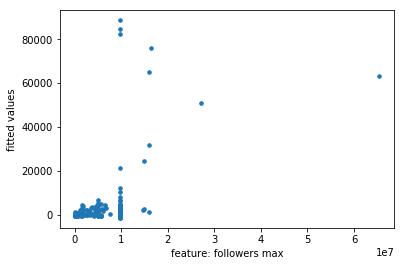

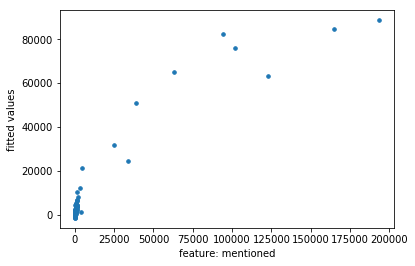

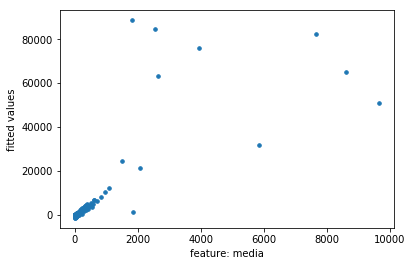

In [25]:
plot_feature_vs_pred(df,pred_y,features,[3,4,5])

#### superbowl

superbowl
MSE for test data =  25640423.019814394
R2 score for test data =  0.9023775660861459


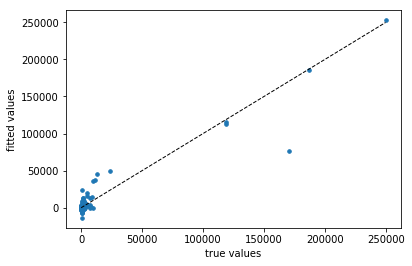

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     665.5
Date:                Wed, 20 Mar 2019   Prob (F-statistic):          2.92e-285
Time:                        00:13:44   Log-Likelihood:                -5820.0
No. Observations:                 585   AIC:                         1.166e+04
Df Residuals:                     576   BIC:                         1.170e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -650.1395    456.622     -1.424

In [26]:
df, df_y, pred_y = train_lr(5)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

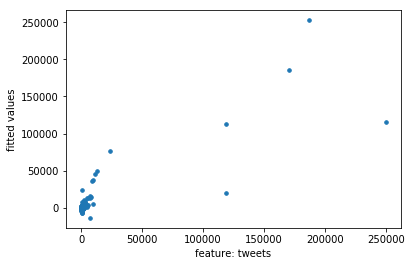

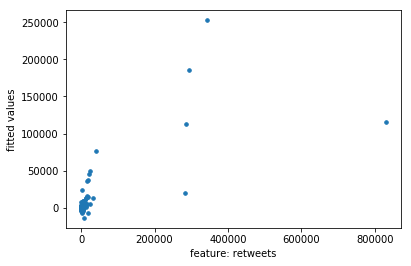

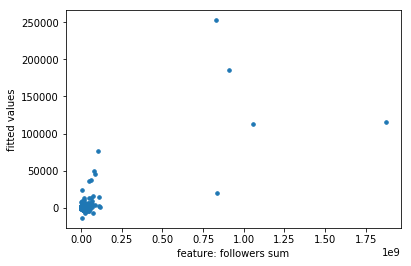

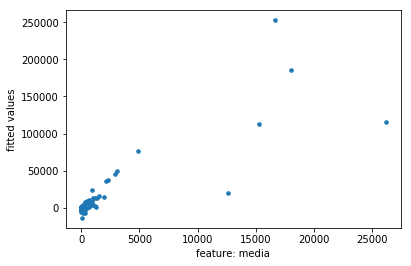

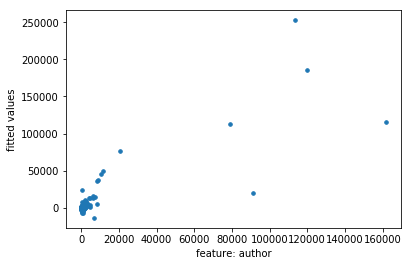

In [27]:
plot_feature_vs_pred(df,pred_y,features,[2,5,7])